# User reviews classifier to predict of a product review will be useful for other users. (Data set Amazon)


**Use Case**: As user prepares and submits a review, how can companies proactively identify reviews not to be posted towards an item that as not a helpful for other users?

**Target Variable** Helpful response from other reviewers (this is a target variable that is constructed by a rating on actual reviews done by other users using the scale from vote or helpful)

**Data Source** https://nijianmo.github.io/amazon/index.html



In [60]:
import os
import json
import gzip
import wget
import pandas as pd
from urllib.request import urlopen
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# tested links
- http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz - works
- http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz - works


In [3]:
##download data from url
### randomly selected file to model
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz'
filename = wget.download(url)


100% [......................................................................] 146631394 / 146631394

In [4]:
#load metadata
data = []
with gzip.open('Grocery_and_Gourmet_Food_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

1143860
{'overall': 5.0, 'verified': True, 'reviewTime': '11 19, 2014', 'reviewerID': 'A1QVBUH9E1V6I8', 'asin': '4639725183', 'reviewerName': 'Jamshed Mathur', 'reviewText': 'No adverse comment.', 'summary': 'Five Stars', 'unixReviewTime': 1416355200}


In [46]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))


1143860


In [47]:
#look at dataframe
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1143860 non-null  float64
 1   verified        1143860 non-null  bool   
 2   reviewTime      1143860 non-null  object 
 3   reviewerID      1143860 non-null  object 
 4   asin            1143860 non-null  object 
 5   reviewerName    1143722 non-null  object 
 6   reviewText      1143470 non-null  object 
 7   summary         1143641 non-null  object 
 8   unixReviewTime  1143860 non-null  int64  
 9   vote            158202 non-null   object 
 10  style           592086 non-null   object 
 11  image           9510 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 97.1+ MB


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


### Data catalogue

- __overall:__- Rating of the Product
- __reviewTime:__- Time of the review (raw)
- __reviewerID:__- ID of the reviewer, e.g. A2SUAM1J3GNN3B
- __asin:__- ID of the product, e.g. 0000013714
- __style:__- A disctionary of the product metadata, e.g., "Format" is "Hardcover"
- __reviewerName:__- Name of the reviewer
- __reviewerText:__- Text of the review
- __summary:__- Summary of the review
- __vote:__- Helpful votes of the review
- __unixReviewTime:__- Time of the review (unix time)
- __reviewText:__- Text of the review
- __image:__- Images that users post after they have received the product

#### Remove Columns

In [56]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

In [55]:
#clean data
#drop columns that don't impact
df = df.drop(['style','summary','image'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1143860 non-null  float64
 1   verified        1143860 non-null  bool   
 2   reviewTime      1143860 non-null  object 
 3   reviewerID      1143860 non-null  object 
 4   asin            1143860 non-null  object 
 5   reviewerName    1143722 non-null  object 
 6   reviewText      1143470 non-null  object 
 7   unixReviewTime  1143860 non-null  int64  
 8   vote            1143860 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 70.9+ MB


In [68]:
#convert column to string
df["reviewText"]=df["reviewText"].astype(str)

In [72]:
#convert vote column to float 
df["vote"]= df["vote"].fillna(0)
df["vote"] = df["vote"].astype(str).astype(float)
df.info()

ValueError: could not convert string to float: '2,088'

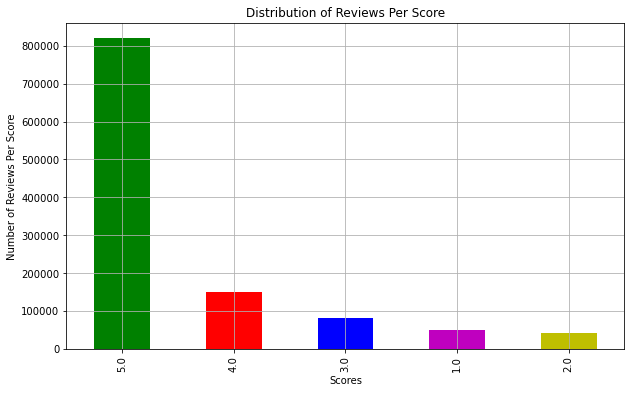

In [61]:
#create graph to check review distribution
category_dist = df['overall'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r', 'b', 'm', 'y']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Scores")
plt.ylabel("Number of Reviews Per Score")
plt.title("Distribution of Reviews Per Score")
plt.show()

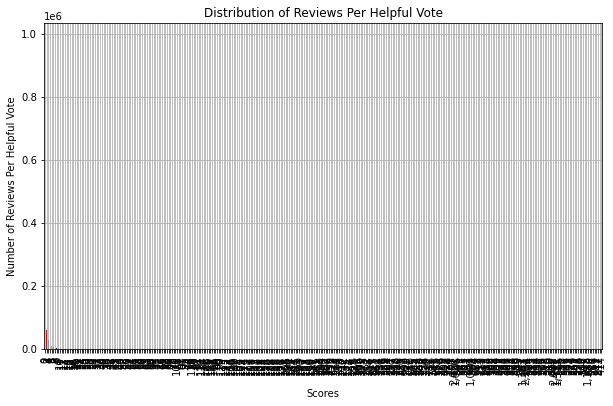

In [63]:
#create graphs to check helpfullness distribution
category_dist = df['vote'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r', 'b', 'm', 'y']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Scores")
plt.ylabel("Number of Reviews Per Helpful Vote")
plt.title("Distribution of Reviews Per Helpful Vote")
plt.show()

average length of review: 208.585


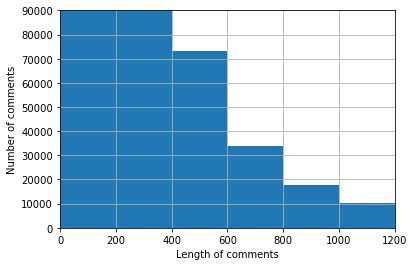

In [69]:
#look at comment length
x = [len(df['reviewText'][i]) for i in range(df['reviewText'].shape[0])]

print('average length of review: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

#

# NLP

In [74]:
import nltk

nltk.download([
    "names",
    "stopwords",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])

ModuleNotFoundError: No module named 'nltk'

In [ ]:
#removes stopwords that are not impactful to text reading
#stop words include
#{‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 

stopwords = nltk.corpus.stopwords.words("english")
stopwords

In [75]:
#import pprint and tokenize test
from pprint import pprint
pprint(nltk.word_tokenize(df['reviewText'][0]), width=79, compact=True)

NameError: name 'nltk' is not defined